# Read raw data csv file and explore info

In [53]:
import pandas as pd
data = pd.read_csv("./data/train.csv")

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [55]:
data.head(5)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


# Data Preprocess

Drop ID from data

In [56]:
data = data.drop(labels=['ID'],axis=1)
y = data['TARGET']
x = data.drop(labels=['TARGET'],axis=1)

In [57]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=777)

Remove features with no variation (variance equals 0)

In [58]:
no_variation_features = x_train.loc[:,x_train.var()==0.0]
no_variation_features = list(no_variation_features.columns)
x_train = x_train.drop(labels=no_variation_features,axis=1)
x_test = x_test.drop(labels=no_variation_features,axis=1)

Correlation Filtering

In [59]:
data_Pearson_correlation = x_train.corr()
duplicate_features_columns = set()

for i in range(len(data_Pearson_correlation.columns)):
  for j in range(i):
    if abs(data_Pearson_correlation.iloc[i, j]) > 0.8:
      duplicate_features_columns.add(data_Pearson_correlation.columns[i])

print(len(duplicate_features_columns))

x_train = x_train.drop(labels=list(duplicate_features_columns),axis=1)
x_test = x_test.drop(labels=list(duplicate_features_columns),axis=1)


197


ExtraTreesClassifier uses tree-based models to evaluate the importance of each feature for predicting the target, and then retains the features most useful to the model.

In [60]:
from sklearn.ensemble import ExtraTreesClassifier

tree = ExtraTreesClassifier(criterion='entropy')
tree.fit(x_train,y_train)

,n_estimators,100
,criterion,'entropy'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [61]:
important_values_list = tree.feature_importances_
important_names_list = tree.feature_names_in_
important_dict = dict()

for i in range(len(important_values_list)):
  important_dict[important_names_list[i]] = important_values_list[i]

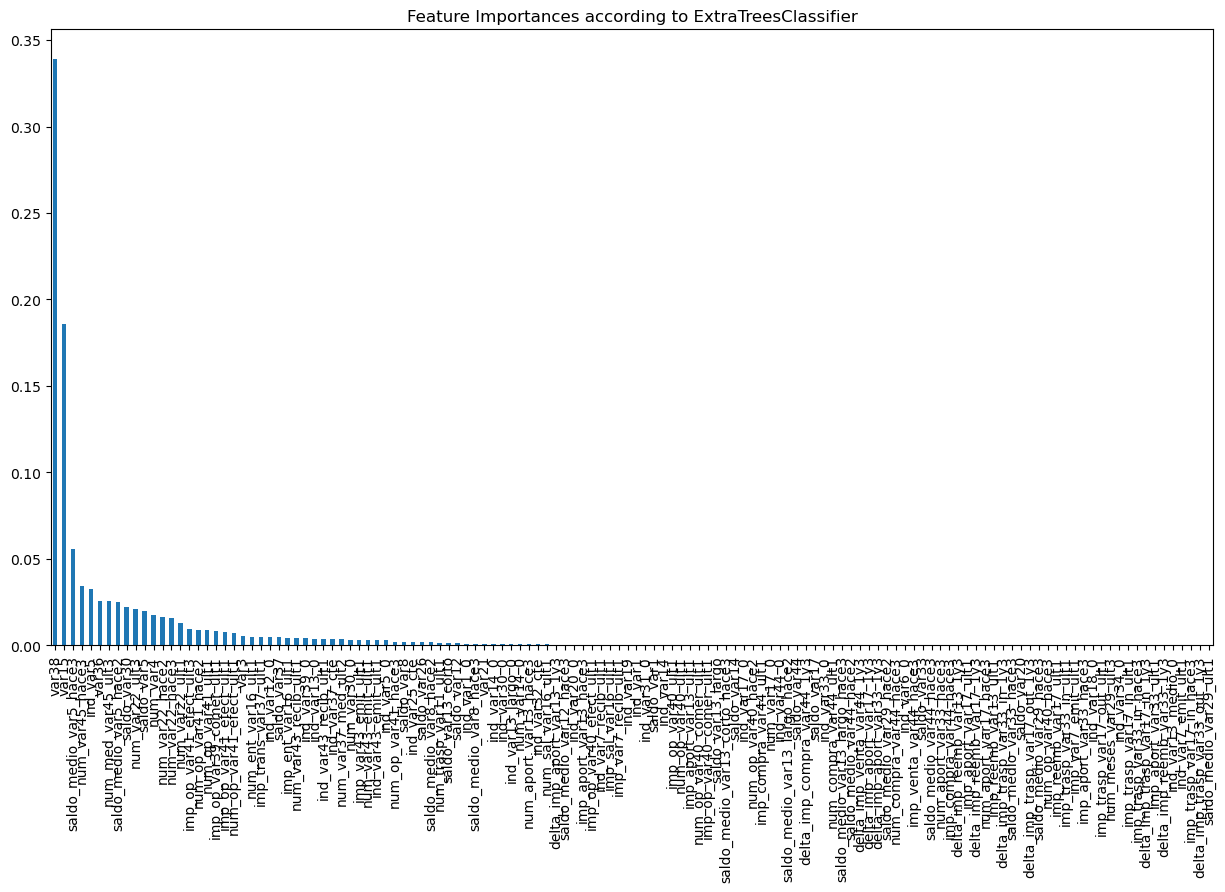

In [62]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
plt.title(label="Feature Importances according to ExtraTreesClassifier")
df_importances = pd.DataFrame(important_dict,index=['Feature Importance'])
df_importances = df_importances.T['Feature Importance']
df_importances.sort_values(ascending=False).plot(kind='bar');

In [63]:
import pandas as pd

df_importances = pd.DataFrame({
    'Feature': df_importances.index,
    'Feature Importance': df_importances.values
})
df_importances = df_importances.sort_values(ascending=False, by=['Feature Importance'])

top_10_percent_index = int(len(df_importances) * 0.10)


to_drop = df_importances.loc[(df_importances['Feature Importance'] == 0) | 
                             (df_importances.index >= top_10_percent_index), 'Feature'].tolist()

x_train = x_train.drop(labels=to_drop, axis=1)
x_test = x_test.drop(labels=to_drop, axis=1)

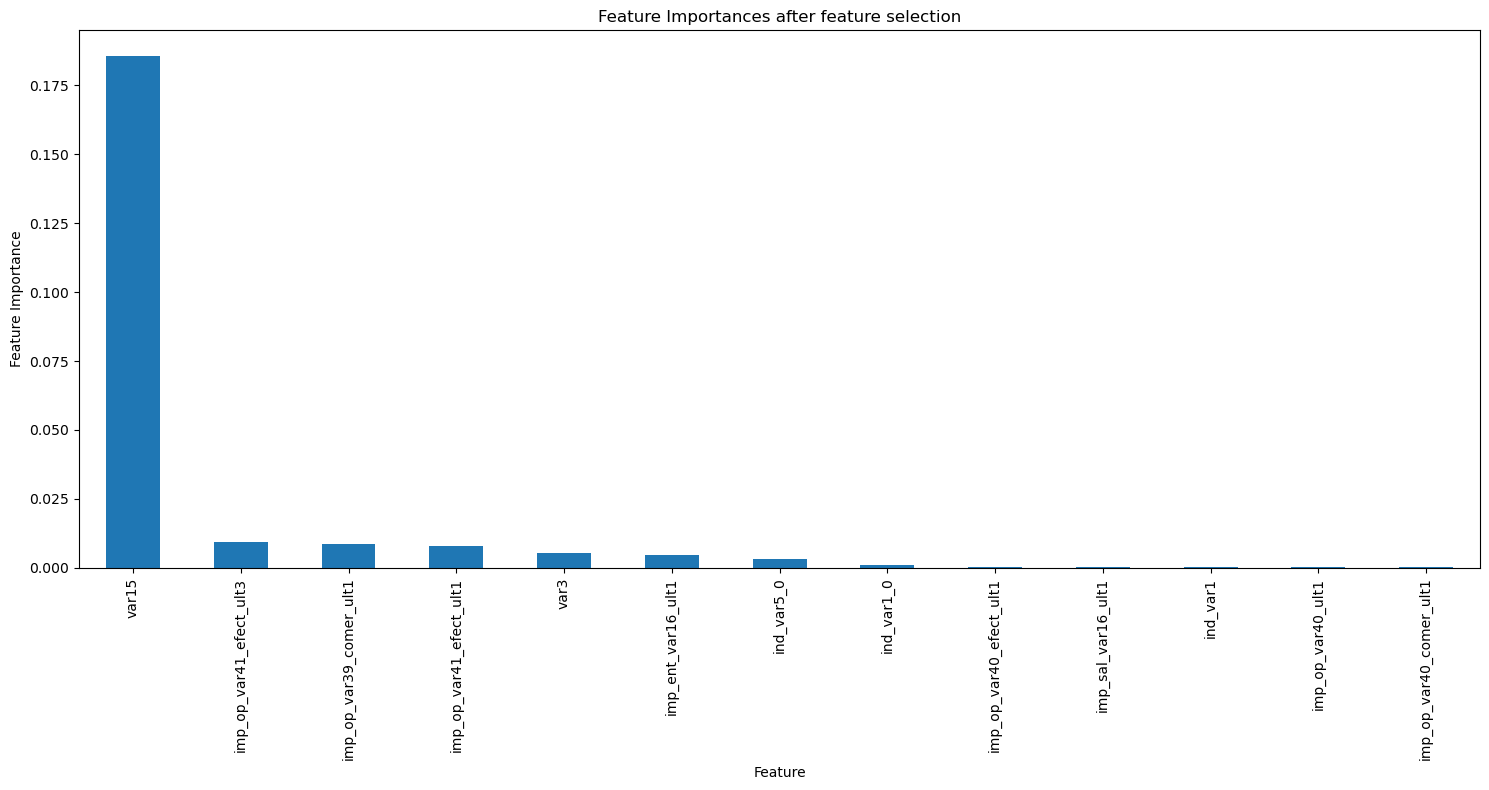

In [64]:
from matplotlib import pyplot as plt
import seaborn as sns

remaining_features = x_train.columns
filtered_imp_dict = {f: important_dict[f] for f in remaining_features if f in important_dict}
df_importances_filtered = pd.Series(filtered_imp_dict).sort_values(ascending=False)

plt.figure(figsize=(15,8))
plt.title("Feature Importances after feature selection")
df_importances_filtered.plot(kind='bar')
plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [65]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

In [66]:
for i in range(3):
    selected_features = df_importances.iloc[:df_importances.shape[0]//(i+1)]['Feature']
    x = data[selected_features].values
    nn = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', verbose=0, max_iter=1000)
    scores = cross_val_score(nn, x, y, cv=5, scoring='roc_auc')
    print("ROC AUC: %f (+/- %f), %d pct of dataset" % (scores.mean(), scores.std(), 100/(i+1)))

ROC AUC: 0.540522 (+/- 0.007385), 100 pct of dataset
ROC AUC: 0.534819 (+/- 0.009579), 50 pct of dataset
ROC AUC: 0.534819 (+/- 0.009579), 50 pct of dataset
ROC AUC: 0.542946 (+/- 0.007612), 33 pct of dataset
ROC AUC: 0.542946 (+/- 0.007612), 33 pct of dataset


In [67]:
selected_features = df_importances.iloc[:df_importances.shape[0]//2]['Feature']
x = data[selected_features].values

params = {'hidden_layer_sizes':[(28,),(28,28,28)],
          'activation':['logistic','relu','tanh'],
          'solver':['sgd','lbfgs','adam']}


In [68]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(MLPClassifier(),param_grid=params,scoring='roc_auc',refit=True)
neural_pipe = make_pipeline(StandardScaler(),SMOTE(),gs)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=777)

neural_pipe.fit(x_train,y_train)
neural_pipe

c:\Users\wei57\anaconda3\envs\data\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\wei57\anaconda3\envs\data\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\wei57\anaconda3\envs\data\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\wei57\anaconda3\envs\data\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\wei57\anaconda3\envs\da

,steps,"[('standardscaler', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,sampling_strategy,'auto'
,random_state,None
,k_neighbors,5
,estimator,MLPClassifier()


In [69]:
#optimized hyper-parameters exhaustively found with GridSearchCV
final_pipeline = make_pipeline(StandardScaler(),SMOTE(),MLPClassifier(hidden_layer_sizes=(28, 56, 28),activation='tanh',solver='adam'))
final_pipeline.fit(x_train,y_train)

c:\Users\wei57\anaconda3\envs\data\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,steps,"[('standardscaler', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,sampling_strategy,'auto'
,random_state,None
,k_neighbors,5
,hidden_layer_sizes,"(28, ...)"


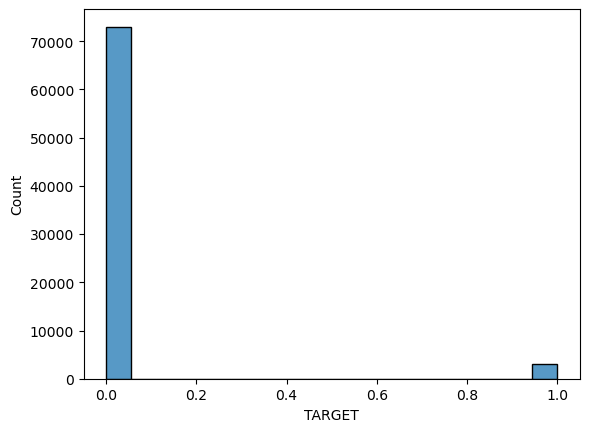

In [70]:
import seaborn as sns
sns.histplot(data['TARGET']);

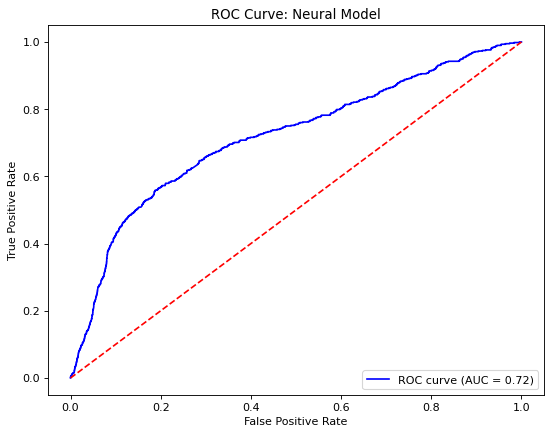

In [71]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = final_pipeline.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Neural Model')
plt.legend(loc='lower right')
plt.show()


In [72]:
from xgboost.sklearn import XGBClassifier
for i in range(3):
    selected_features = df_importances.iloc[:df_importances.shape[0]//(i+1)]['Feature']
    x = data[selected_features].values
    xgb_model = XGBClassifier()
    scores = cross_val_score(xgb_model, x, y, cv=5, scoring='roc_auc')
    print("ROC AUC: %f (+/- %f), %d pct of dataset" % (scores.mean(), scores.std(), 100/(i+1)))


ROC AUC: 0.815725 (+/- 0.010920), 100 pct of dataset
ROC AUC: 0.816889 (+/- 0.010702), 50 pct of dataset
ROC AUC: 0.816889 (+/- 0.010702), 50 pct of dataset
ROC AUC: 0.814880 (+/- 0.009156), 33 pct of dataset
ROC AUC: 0.814880 (+/- 0.009156), 33 pct of dataset


In [73]:
selected_features = df_importances.iloc[:df_importances.shape[0]//2]['Feature']
x = data[selected_features].values

In [74]:
xgb_model = XGBClassifier()


In [75]:
'''
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'xgbclassifier__booster': ['dart'],
    'xgbclassifier__n_estimators': [200, 7000],
    'xgbclassifier__learning_rate': [0.005, 0.05],
    'xgbclassifier__max_depth': [3, 30],
    'xgbclassifier__min_child_weight': [3, 10]
}

random_search = RandomizedSearchCV(xgb_pipe, param_distributions=param_distributions,
                                   n_iter=12, cv=5, random_state=42, scoring='roc_auc', verbose=1)

random_search.fit(x_train, y_train)

best_params = random_search.best_params_
print(best_params)

best_params_clean = {k.replace('xgbclassifier__',''): v for k, v in best_params.items()}
print(best_params_clean)

from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

xgb_pipe = make_pipeline(
    XGBClassifier(
        **best_params_clean,   
        subsample=0.68,        
        colsample_bytree=0.9,
        random_state=777,
        eval_metric='auc'
    )
)

score = cross_val_score(xgb_pipe, x, y, scoring='roc_auc')
print("Mean ROC AUC:", score.mean())

'''

'\nfrom sklearn.model_selection import RandomizedSearchCV\n\nparam_distributions = {\n    \'xgbclassifier__booster\': [\'dart\'],\n    \'xgbclassifier__n_estimators\': [200, 7000],\n    \'xgbclassifier__learning_rate\': [0.005, 0.05],\n    \'xgbclassifier__max_depth\': [3, 30],\n    \'xgbclassifier__min_child_weight\': [3, 10]\n}\n\nrandom_search = RandomizedSearchCV(xgb_pipe, param_distributions=param_distributions,\n                                   n_iter=12, cv=5, random_state=42, scoring=\'roc_auc\', verbose=1)\n\nrandom_search.fit(x_train, y_train)\n\nbest_params = random_search.best_params_\nprint(best_params)\n\nbest_params_clean = {k.replace(\'xgbclassifier__\',\'\'): v for k, v in best_params.items()}\nprint(best_params_clean)\n\nfrom sklearn.pipeline import make_pipeline\nfrom xgboost import XGBClassifier\nfrom sklearn.model_selection import cross_val_score\n\nxgb_pipe = make_pipeline(\n    XGBClassifier(\n        **best_params_clean,   \n        subsample=0.68,        \n  

In [76]:
xgb_pipe = make_pipeline(XGBClassifier(n_estimators=500,max_depth=5,learning_rate=0.02,subsample= 0.68,colsample_bytree= 0.9,random_state=777,eval_metric = 'auc'))
score = cross_val_score(xgb_pipe,x,y,scoring='roc_auc')
score.mean()

np.float64(0.8389328397025914)

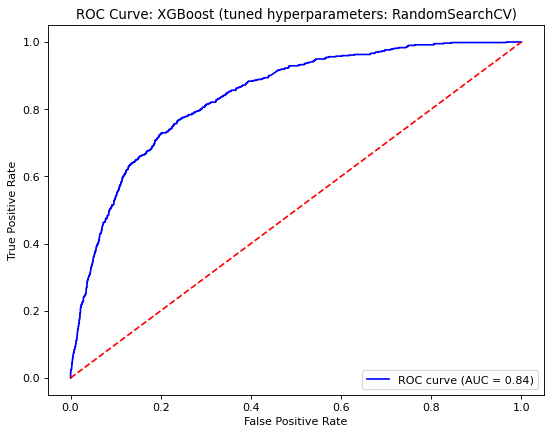

In [77]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

xgb_pipe.fit(x_train, y_train)

y_score = xgb_pipe.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: XGBoost (tuned hyperparameters: RandomSearchCV)')
plt.legend(loc='lower right')
plt.show()


In [78]:
model =XGBClassifier(n_estimators=500,max_depth=5,learning_rate=0.02,subsample= 0.68,colsample_bytree= 0.9,random_state=777,eval_metric = 'auc')
model.fit(x,y)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [79]:
test_df = pd.read_csv("./data/test.csv")
submission_df = pd.DataFrame()
submission_df['ID'] = test_df['ID']
submission_df.set_index('ID',inplace=True)
test_df.drop(labels=['ID'],axis=1,inplace=True)
test_df = test_df[selected_features]
predictions = model.predict_proba(test_df.values)
submission_df['TARGET'] = predictions[:,1]
submission_df.to_csv('submission.csv')